In [5]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Load small instance data
with open("InputDataHubSmallInstance.json", "r") as f:
    data = json.load(f)

# Extract problem data
N = int(data["NodeNum"])
flow = np.array(data["flow(wij)"])
varCost = np.array(data["varCost(cij)"])
fixCost = np.array(data["fixCost(fk)"])
alpha = data["alpha"]
capacity = np.array(data["Cap(ckmax)"])

# Parameters for small data
MAX_ITER = 1000     # Fewer iterations needed
MAX_NO_IMPROVE = 200
HUB_NUM = 8        # You may adjust based on your use-case

# Cost calculation
def calculate_total_cost(hub_locs, allocation):
    total_cost = 0
    for i in range(N):
        for j in range(N):
            h_i = allocation[i]
            h_j = allocation[j]
            trans_cost = alpha * varCost[i][h_i] + varCost[h_i][h_j] + alpha * varCost[h_j][j]
            total_cost += flow[i][j] * trans_cost

    # Add fixed costs
    for h in hub_locs:
        total_cost += fixCost[h]
    return total_cost

# Capacity check
def is_feasible(hub_locs, allocation):
    loads = [0] * N
    for i in range(N):
        h = allocation[i]
        loads[h] += sum(flow[i]) + sum(flow[:, i])
    for h in hub_locs:
        if loads[h] > capacity[h]:
            return False
    return True

# Initial solution generator
def generate_initial_solution():
    hub_locs = random.sample(range(N), HUB_NUM)
    allocation = []
    for i in range(N):
        min_cost = float('inf')
        assigned = None
        for h in hub_locs:
            cost = varCost[i][h]
            if cost < min_cost:
                min_cost = cost
                assigned = h
        allocation.append(assigned)
    if not is_feasible(hub_locs, allocation):
        return generate_initial_solution()  # Retry
    return hub_locs, allocation

# Local search
def local_search(hub_locs, allocation):
    best_cost = calculate_total_cost(hub_locs, allocation)
    improved = True

    while improved:
        improved = False
        for i in range(N):
            for h in hub_locs:
                if allocation[i] == h:
                    continue
                new_allocation = allocation.copy()
                new_allocation[i] = h
                if is_feasible(hub_locs, new_allocation):
                    new_cost = calculate_total_cost(hub_locs, new_allocation)
                    if new_cost < best_cost:
                        allocation = new_allocation
                        best_cost = new_cost
                        improved = True
    return hub_locs, allocation, best_cost


def is_feasible(hub_locs, allocation):
    total_flow = np.zeros(N)
    for i in range(N):
        assigned_hub = allocation[i]
        for j in range(N):
            total_flow[assigned_hub] += flow[i][j]

    return all(total_flow[h] <= capacity[h] for h in hub_locs)

def generate_initial_solution(max_retries=1000):
    for _ in range(max_retries):
        hub_locs = random.sample(range(N), HUB_NUM)
        allocation = []
        for i in range(N):
            assigned = min(hub_locs, key=lambda h: varCost[i][h])
            allocation.append(assigned)
        if is_feasible(hub_locs, allocation):
            return hub_locs, allocation
    raise ValueError("Failed to generate a feasible solution after several attempts.")

def ILS(num_initial_solutions=100):
    best_solution = None
    best_cost = float('inf')

    for iteration in range(num_initial_solutions):
        hubs, alloc = generate_initial_solution()
        
        # Print initial solution hubs and allocations
        print(f"Initial Solution {iteration+1}: Hubs = {hubs}, Allocation = {alloc}")
        
        hubs, alloc, cost = local_search(hubs, alloc)
        
        if cost < best_cost:
            best_cost = cost
            best_solution = (hubs.copy(), alloc.copy())
    
    return best_solution, best_cost



# Run ILS 100 times, pick solution closest to target cost
NUM_FULL_RUNS = 100
target_cost = 6794788.65

best_diff = float('inf')
best_solution_by_diff = None
best_cost_by_diff = None

for run in range(NUM_FULL_RUNS):
    solution, cost = ILS()
    diff = abs(cost - target_cost)
    if diff < best_diff:
        best_diff = diff
        best_solution_by_diff = solution
        best_cost_by_diff = cost  # Save the cost of the best solution
    
    print(f"Full Run {run+1}/{NUM_FULL_RUNS}: Best diff so far = {best_diff:.2f}")

hub_locs, allocation = best_solution_by_diff
print("\nBest solution closest to target cost after 100 full ILS runs:")
print("Selected Hub Locations:", hub_locs)
print("Node Allocation:", allocation)
print("Total Cost:", best_cost_by_diff)  # print correct best cost here

Initial Solution 1: Hubs = [2, 1, 7, 0, 4, 6, 3, 5], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 2: Hubs = [7, 2, 0, 3, 6, 4, 5, 1], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 3: Hubs = [2, 1, 3, 5, 4, 0, 7, 6], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 4: Hubs = [4, 6, 0, 3, 2, 5, 7, 1], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 5: Hubs = [7, 5, 4, 6, 3, 2, 0, 1], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 6: Hubs = [5, 3, 6, 7, 0, 2, 4, 1], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 7: Hubs = [1, 6, 3, 5, 0, 4, 2, 7], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 8: Hubs = [2, 6, 1, 5, 7, 4, 0, 3], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 9: Hubs = [3, 4, 1, 2, 7, 6, 0, 5], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 10: Hubs = [0, 7, 3, 5, 2, 4, 6, 1], Allocation = [0, 1, 2, 3, 4, 5, 6, 7]
Initial Solution 11: Hubs = [2, 1, 0, 4, 3, 5, 6, 7], Allocation = [0, 1, 2, 3, 4, 5, 6, 

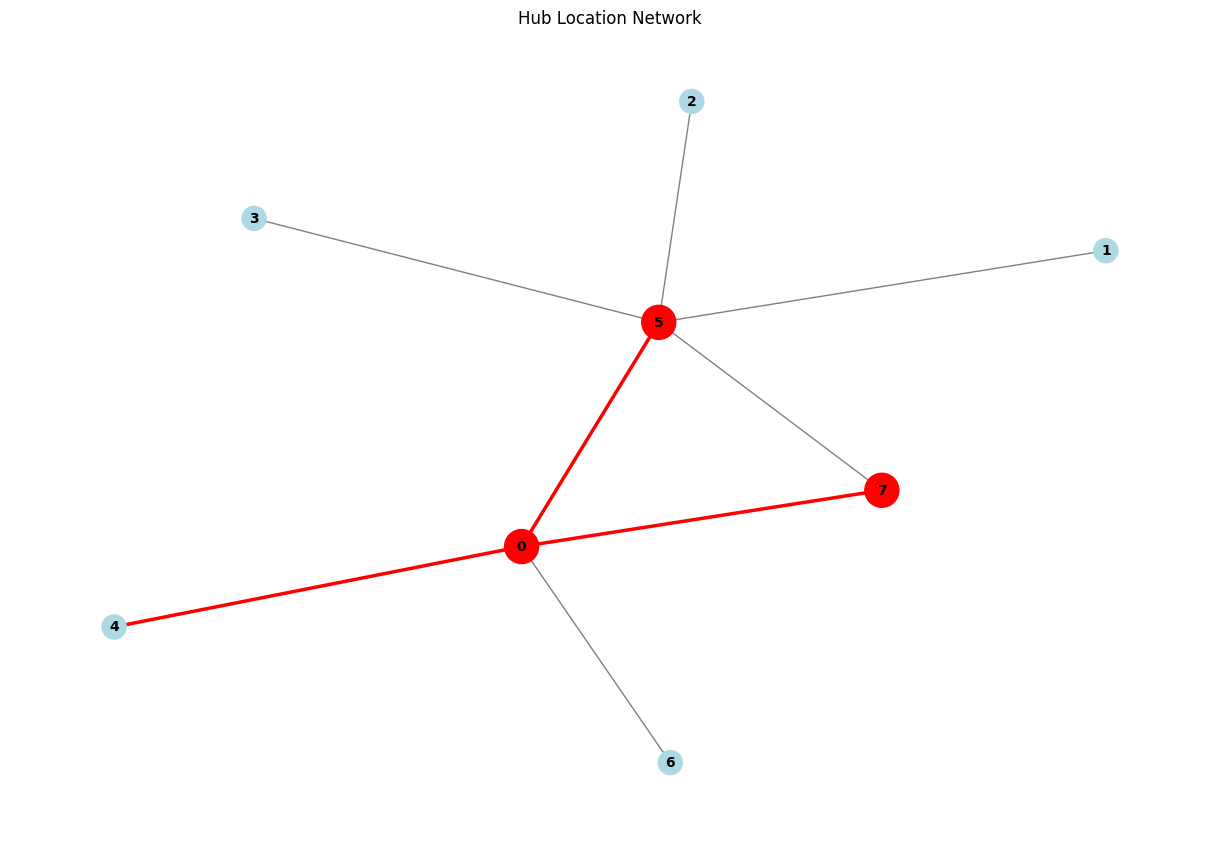

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_hub_network(hub_locs, allocation):
    nodes = list(range(len(allocation)))
    hubs = hub_locs

    # Create graph
    G = nx.Graph()
    G.add_nodes_from(nodes)

    # Node colors and sizes
    node_colors = ['red' if node in hubs else 'lightblue' for node in nodes]
    node_sizes = [600 if node in hubs else 300 for node in nodes]

    # Edges
    edges = []
    edge_colors = []
    edge_widths = []

    # Add hub-hub links (if needed)
    # For visualization, connect hubs with edges (optional)
    for i in range(len(hubs)):
        for j in range(i + 1, len(hubs)):
            edges.append((hubs[i], hubs[j]))
            edge_colors.append('red')
            edge_widths.append(2.5)

    # Add allocations edges: node to assigned hub (skip hubs self-loops)
    for node, hub in enumerate(allocation):
        if node != hub:
            edges.append((node, hub))
            edge_colors.append('gray')
            edge_widths.append(1.0)

    G.add_edges_from(edges)

    # Layout (try Kamada-Kawai for better spacing)
    pos = nx.kamada_kawai_layout(G)

    # Draw graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color=edge_colors,
        width=edge_widths,
        with_labels=True,
        font_weight='bold',
        font_color='black',
        font_size=10,
    )
    plt.title("Hub Location Network")
    plt.show()


# Call this after you get your solution
plot_hub_network(hub_locs, allocation)
